In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as pl
%matplotlib inline
from scipy import stats
import shap

import warnings
warnings.filterwarnings("ignore")

from aif360.datasets import BinaryLabelDataset
from aif360.metrics import BinaryLabelDatasetMetric, ClassificationMetric
from aif360.algorithms.preprocessing.reweighing import Reweighing
from aif360.algorithms.inprocessing.prejudice_remover import PrejudiceRemover
from aif360.algorithms.preprocessing import DisparateImpactRemover

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.neighbors import NearestNeighbors

/home/juliana/miniconda3/envs/pytevec/lib/python3.5/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [3]:
#Functions

def consitency_mod(metric, col,n_neighbors=5):
    #Function to calculate consistency
    X = metric.dataset.features
    X = np.delete(X, col, 1)
    X = StandardScaler().fit_transform(X) 
    num_samples = X.shape[0]
    y = metric.dataset.labels

    # learn a KNN on the features
    nbrs = NearestNeighbors(n_neighbors, algorithm='ball_tree').fit(X)
    _, indices = nbrs.kneighbors(X)

    # compute consistency score
    consistency = 0.0
    for i in range(num_samples):
        consistency += np.abs(y[i] - np.mean(y[indices[i]]))
    consistency = 1.0 - consistency/num_samples

    return consistency

## Loading data

In [4]:
path = ''
df_original = pd.read_csv(path + 'data/compas-scores-two-years.csv')
print(df_original.shape)
cols_name = ['race', 'age', 'c_charge_degree', 'v_score_text', 'sex', 
             'priors_count', 'days_b_screening_arrest', 'v_decile_score', 
             'two_year_recid']

df_original = df_original[cols_name]
df_original = df_original[(df_original['days_b_screening_arrest'] <= 30) &
                          (df_original['days_b_screening_arrest'] >= -30)]
print(df_original.shape)
df_original.head(2)

(7214, 53)
(6172, 9)


,race,age,c_charge_degree,v_score_text,sex,priors_count,days_b_screening_arrest,v_decile_score,two_year_recid
0,Other,69,F,Low,Male,0,-1.0,1,0
1,African-American,34,F,Low,Male,0,-1.0,1,1


In [5]:
df_original.two_year_recid = df_original.two_year_recid.replace({0:1, 1:0})
df_original.two_year_recid.value_counts()

1    3363
0    2809
Name: two_year_recid, dtype: int64

## Preprocessing

In [7]:
df_proces = df_original.copy()
df_proces = df_proces.fillna('0')
df_proces['race'] = df_proces['race'].apply(lambda row: 1 if row == 'Caucasian' else 0)

columns_cat = ['c_charge_degree', 'v_score_text', 'sex']
lb_encoder = LabelEncoder()
for col_cat in columns_cat:  
    df_proces[col_cat] = lb_encoder.fit_transform(df_proces[col_cat])

df_proces = df_proces.astype(float)
df_proces.head()

,race,age,c_charge_degree,v_score_text,sex,priors_count,days_b_screening_arrest,v_decile_score,two_year_recid
0,0.0,69.0,0.0,1.0,1.0,0.0,-1.0,1.0,1.0
1,0.0,34.0,0.0,1.0,1.0,0.0,-1.0,1.0,0.0
2,0.0,24.0,0.0,1.0,1.0,4.0,-1.0,3.0,0.0
5,0.0,44.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0
6,1.0,41.0,0.0,1.0,1.0,14.0,-1.0,2.0,0.0


In [9]:
for col_cat in columns_cat:  
    one_hot = OneHotEncoder(sparse=False)
    res = one_hot.fit_transform(df_proces[[col_cat]])
    num_col = res.shape[1]
    for idx in range(num_col):
        df_proces['{}_{}'.format(col_cat, idx)] = res[:, idx]
        
df_proces.drop(columns_cat, axis=1, inplace=True)
df_proces.head()

,race,age,priors_count,days_b_screening_arrest,v_decile_score,two_year_recid,c_charge_degree_0,c_charge_degree_1,v_score_text_0,v_score_text_1,v_score_text_2,sex_0,sex_1
0,0.0,69.0,0.0,-1.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0
1,0.0,34.0,0.0,-1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0
2,0.0,24.0,4.0,-1.0,3.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0
5,0.0,44.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0
6,1.0,41.0,14.0,-1.0,2.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0


In [10]:
metadata = {'label_maps': [{0.0: 'Bad', 1.0: 'Good'}], 
            'protected_attribute_maps': [{0.0: 'Not Caucasian', 1.0: 'Caucasian'}]}
unprivileged_groups=[{'race': [0.0]}]
privileged_groups=[{'race': [1.0]}]
protected_attribute_names = ['race']
label_names = ['two_year_recid']
dataset = BinaryLabelDataset(df = df_proces, label_names=label_names, 
                            protected_attribute_names = protected_attribute_names, 
                            instance_weights_name=None, unprivileged_protected_attributes=[], 
                            privileged_protected_attributes=[], metadata=metadata)

metric_orig = BinaryLabelDatasetMetric(dataset,
                                       unprivileged_groups=unprivileged_groups,
                                       privileged_groups=privileged_groups)
disparate_impact_orig = metric_orig.disparate_impact()
print('Disparate impact dados originais: ', (1 - disparate_impact_orig))
position = 0

Disparate impact dados originais:  0.15999247178213294


In [0]:
lst_res = []

## Model with original data

In [0]:
dataset_train, dataset_test = dataset.split([0.7], shuffle=False)

scale = StandardScaler().fit(dataset_train.features)  
X_train_orig = scale.transform(dataset_train.features)     
y_train = dataset_train.labels.ravel()
X_test_orig = scale.transform(dataset_test.features)   
y_test = dataset_test.labels.ravel()

### Random Forest

In [13]:
model_orig_rf = RandomForestClassifier()
model_orig_rf.fit(X_train_orig, y_train) 

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [14]:
y_pred_test = model_orig_rf.predict(X_test_orig)
acc_test = accuracy_score(y_true=y_test, y_pred=y_pred_test)
print("Acuracia teste: ", acc_test)
y_pred_train = model_orig_rf.predict(X_train_orig)
acc_train = accuracy_score(y_true=y_train, y_pred=y_pred_train)
print("Acuracia treino: ", acc_train)

dataset_pred = dataset_test.copy()
dataset_pred.labels = y_pred_test

metric_orig_pred_rf = BinaryLabelDatasetMetric(dataset_pred,
                                           unprivileged_groups=unprivileged_groups,
                                           privileged_groups=privileged_groups)
disparate_impact_orig_pred_rf = metric_orig_pred_rf.disparate_impact()
print('Disparate impact previsão com dados originais: ', (1 - disparate_impact_orig_pred_rf))
mean_difference_orig_pred_rf = metric_orig_pred_rf.mean_difference()
print('Mean difference previsão com dados originais: ', mean_difference_orig_pred_rf)

classif_metric_orig_pred_rf = ClassificationMetric(dataset_test, dataset_pred, 
                                      unprivileged_groups=unprivileged_groups,
                                      privileged_groups=privileged_groups)
classif_disparete_impact_orig_pred_rf = classif_metric_orig_pred_rf.disparate_impact()
print('Classif. disparete previsão com dados originais', 1 - classif_disparete_impact_orig_pred_rf)
avg_odds_orig_pred_rf = classif_metric_orig_pred_rf.average_odds_difference()
print('average_odds_difference previsão com dados originais:', avg_odds_orig_pred_rf)
equal_opport_orig_pred_rf = classif_metric_orig_pred_rf.equal_opportunity_difference()
print('equal_opportunity_difference previsão com dados originais:', equal_opport_orig_pred_rf)
false_discovery_rate_orig_pred_rf = classif_metric_orig_pred_rf.false_discovery_rate_difference()
print('false_discovery_rate_difference previsão com dados originais:', false_discovery_rate_orig_pred_rf)
cons_comp_orig_pred_rf = consitency_mod(metric_orig_pred_rf, position,n_neighbors=5)
print('Consistency comparative: ', cons_comp_orig_pred_rf)

entropy_index_orig_pred_rf = classif_metric_orig_pred_rf.generalized_entropy_index()
print('generalized_entropy_index previsão com dados originais:', entropy_index_orig_pred_rf)

lst_res.append(('adult', 'rf_orig', acc_test, 1-disparate_impact_orig_pred_rf, mean_difference_orig_pred_rf,
                1 - classif_disparete_impact_orig_pred_rf, avg_odds_orig_pred_rf, equal_opport_orig_pred_rf,
                false_discovery_rate_orig_pred_rf, entropy_index_orig_pred_rf, cons_comp_orig_pred_rf))

Acuracia teste:  0.6177105831533477
Acuracia treino:  0.9164351851851852
Disparate impact previsão com dados originais:  0.2220031374860244
Mean difference previsão com dados originais:  -0.13435141330060374
Classif. disparete previsão com dados originais 0.2220031374860244
average_odds_difference previsão com dados originais: -0.11587976659637031
equal_opportunity_difference previsão com dados originais: -0.07014357673988281
false_discovery_rate_difference previsão com dados originais: 0.04307988255543177
(1852, 12)
(1852, 11)
Consistency comparative:  0.7704103671706284
generalized_entropy_index previsão com dados originais: 0.19943326072443235


### Logistic Regression

In [15]:
model_orig_lr = LogisticRegression()
model_orig_lr.fit(X_train_orig, y_train) 

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

In [16]:
y_pred_test = model_orig_lr.predict(X_test_orig)
acc_test = accuracy_score(y_true=y_test, y_pred=y_pred_test)
print("Acuracia teste: ", acc_test)
y_pred_train = model_orig_lr.predict(X_train_orig)
acc_train = accuracy_score(y_true=y_train, y_pred=y_pred_train)
print("Acuracia treino: ", acc_train)

dataset_pred = dataset_test.copy()
dataset_pred.labels = y_pred_test

metric_orig_pred_lr = BinaryLabelDatasetMetric(dataset_pred,
                                           unprivileged_groups=unprivileged_groups,
                                           privileged_groups=privileged_groups)
disparate_impact_orig_pred_lr = metric_orig_pred_lr.disparate_impact()
print('Disparate impact previsão com dados originais: ', (1 - disparate_impact_orig_pred_lr))
mean_difference_orig_pred_lr = metric_orig_pred_lr.mean_difference()
print('Mean difference previsão com dados originais: ', mean_difference_orig_pred_lr)

classif_metric_orig_pred_lr = ClassificationMetric(dataset_test, dataset_pred, 
                                      unprivileged_groups=unprivileged_groups,
                                      privileged_groups=privileged_groups)
classif_disparete_impact_orig_pred_lr = classif_metric_orig_pred_lr.disparate_impact()
print('Classif. disparete previsão com dados originais', 1 - classif_disparete_impact_orig_pred_lr)
avg_odds_orig_pred_lr = classif_metric_orig_pred_lr.average_odds_difference()
print('average_odds_difference previsão com dados originais:', avg_odds_orig_pred_lr)
equal_opport_orig_pred_lr = classif_metric_orig_pred_lr.equal_opportunity_difference()
print('equal_opportunity_difference previsão com dados originais:', equal_opport_orig_pred_lr)
false_discovery_rate_orig_pred_lr = classif_metric_orig_pred_lr.false_discovery_rate_difference()
print('false_discovery_rate_difference previsão com dados originais:', false_discovery_rate_orig_pred_lr)
cons_comp_orig_pred_lr = consitency_mod(metric_orig_pred_lr, position,n_neighbors=5)
print('Consistency comparative: ', cons_comp_orig_pred_lr)

entropy_index_orig_pred_lr = classif_metric_orig_pred_lr.generalized_entropy_index()
print('generalized_entropy_index previsão com dados originais:', entropy_index_orig_pred_lr)

lst_res.append(('adult', 'lr_orig', acc_test, 1-disparate_impact_orig_pred_lr, mean_difference_orig_pred_lr,
                1 - classif_disparete_impact_orig_pred_lr, avg_odds_orig_pred_lr, equal_opport_orig_pred_lr,
                false_discovery_rate_orig_pred_lr, entropy_index_orig_pred_lr, cons_comp_orig_pred_lr))

Acuracia teste:  0.6657667386609071
Acuracia treino:  0.6826388888888889
Disparate impact previsão com dados originais:  0.218032926725241
Mean difference previsão com dados originais:  -0.16087866437978948
Classif. disparete previsão com dados originais 0.218032926725241
average_odds_difference previsão com dados originais: -0.1317537994216597
equal_opportunity_difference previsão com dados originais: -0.09777524586231712
false_discovery_rate_difference previsão com dados originais: 0.056130494776266526
(1852, 12)
(1852, 11)
Consistency comparative:  0.9558315334773217
generalized_entropy_index previsão com dados originais: 0.13613278463648845


## Model with transformed data

In [0]:
RW = Reweighing(unprivileged_groups=unprivileged_groups,
                privileged_groups=privileged_groups)
RW.fit(dataset_train)
dataset_transf_train = RW.transform(dataset_train)

In [18]:
metric_transf = BinaryLabelDatasetMetric(dataset_transf_train,
                                         unprivileged_groups=unprivileged_groups,
                                         privileged_groups=privileged_groups)
disparate_impact_transf = metric_transf.disparate_impact()
print('Disparate impact dados transformados: ', (1 - disparate_impact_transf))

Disparate impact dados transformados:  0.0


In [0]:
scale_transf = StandardScaler().fit(dataset_transf_train.features) 
X_train_transf = scale.transform(dataset_transf_train.features)  
y_train = dataset_transf_train.labels.ravel()
X_test_transf = scale_transf.transform(dataset_test.features) 
y_test = dataset_test.labels.ravel()

### Random Forest

In [20]:
model_transf_rf = RandomForestClassifier()
model_transf_rf.fit(X_train_transf, y_train,
                 sample_weight=dataset_transf_train.instance_weights)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [21]:
y_pred_test = model_transf_rf.predict(X_test_transf)

acc_test = accuracy_score(y_true=y_test, y_pred=y_pred_test)
print("Acuracia teste: ", acc_test)

dataset_pred = dataset_test.copy()
dataset_pred.labels = y_pred_test

metric_pred_transf_rf = BinaryLabelDatasetMetric(dataset_pred,
                                             unprivileged_groups=unprivileged_groups,
                                             privileged_groups=privileged_groups)
disparate_impact_transf_pred_rf = metric_pred_transf_rf.disparate_impact()
mean_difference_transf_pred_rf = metric_pred_transf_rf.mean_difference()
print('Disparate impact previsão com dados transformados: ', (1 - disparate_impact_transf_pred_rf))
print('Mean difference previsão com dados transformados: ', mean_difference_transf_pred_rf)

classif_metric_transf_pred_rf = ClassificationMetric(dataset_test, dataset_pred, 
                                      unprivileged_groups=unprivileged_groups,
                                      privileged_groups=privileged_groups)
classif_disparete_impact_transf_pred_rf = classif_metric_transf_pred_rf.disparate_impact()
print('Classif. disparete previsão com dados transformados', 1 - classif_disparete_impact_transf_pred_rf)
avg_odds_transf_pred_rf = classif_metric_transf_pred_rf.average_odds_difference()
print('average_odds_difference previsão com dados transformados:', avg_odds_transf_pred_rf)
equal_opport_transf_pred_rf = classif_metric_transf_pred_rf.equal_opportunity_difference()
print('equal_opportunity_difference previsão com dados transformados:', equal_opport_transf_pred_rf)
false_discovery_rate_transf_pred_rf = classif_metric_transf_pred_rf.false_discovery_rate_difference()
print('false_discovery_rate_difference previsão com dados transformados:', false_discovery_rate_transf_pred_rf)
cons_comp_transf_pred_rf = consitency_mod(metric_pred_transf_rf, position,n_neighbors=5)
print('Consistency comparative: ', cons_comp_transf_pred_rf)

entropy_index_transf_pred_rf = classif_metric_transf_pred_rf.generalized_entropy_index()
print('generalized_entropy_index previsão com dados transformados:', entropy_index_transf_pred_rf)

lst_res.append(('adult', 'rf_transf', acc_test, 1-disparate_impact_transf_pred_rf, 
                mean_difference_transf_pred_rf, 1 - classif_disparete_impact_transf_pred_rf,
                avg_odds_transf_pred_rf, equal_opport_transf_pred_rf,
                false_discovery_rate_transf_pred_rf, entropy_index_transf_pred_rf, cons_comp_transf_pred_rf))


Acuracia teste:  0.6214902807775378
Disparate impact previsão com dados transformados:  0.18463104598363178
Mean difference previsão com dados transformados:  -0.10844833283504585
Classif. disparete previsão com dados transformados 0.18463104598363178
average_odds_difference previsão com dados transformados: -0.08091790807699054
equal_opportunity_difference previsão com dados transformados: -0.08658294212383932
false_discovery_rate_difference previsão com dados transformados: 0.09145446155136971
(1852, 12)
(1852, 11)
Consistency comparative:  0.7657667386609088
generalized_entropy_index previsão com dados transformados: 0.1976648318561244


### Logistic Regression

In [22]:
model_transf_lr = LogisticRegression()
model_transf_lr.fit(X_train_transf, y_train,
                    sample_weight=dataset_transf_train.instance_weights)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

In [23]:
y_pred_test = model_transf_lr.predict(X_test_transf)

acc_test = accuracy_score(y_true=y_test, y_pred=y_pred_test)
print("Acuracia teste: ", acc_test)

dataset_pred = dataset_test.copy()
dataset_pred.labels = y_pred_test

metric_pred_transf_lr = BinaryLabelDatasetMetric(dataset_pred,
                                             unprivileged_groups=unprivileged_groups,
                                             privileged_groups=privileged_groups)
disparate_impact_transf_pred_lr = metric_pred_transf_lr.disparate_impact()
mean_difference_transf_pred_lr = metric_pred_transf_lr.mean_difference()
print('Disparate impact previsão com dados transformados: ', (1 - disparate_impact_transf_pred_lr))
print('Mean difference previsão com dados transformados: ', mean_difference_transf_pred_lr)

classif_metric_transf_pred_lr = ClassificationMetric(dataset_test, dataset_pred, 
                                      unprivileged_groups=unprivileged_groups,
                                      privileged_groups=privileged_groups)
classif_disparete_impact_transf_pred_lr = classif_metric_transf_pred_lr.disparate_impact()
print('Classif. disparete previsão com dados transformados', 1 - classif_disparete_impact_transf_pred_lr)
avg_odds_transf_pred_lr = classif_metric_transf_pred_lr.average_odds_difference()
print('average_odds_difference previsão com dados transformados:', avg_odds_transf_pred_lr)
equal_opport_transf_pred_lr = classif_metric_transf_pred_lr.equal_opportunity_difference()
print('equal_opportunity_difference previsão com dados transformados:', equal_opport_transf_pred_lr)
false_discovery_rate_transf_pred_lr = classif_metric_transf_pred_lr.false_discovery_rate_difference()
print('false_discovery_rate_difference previsão com dados transformados:', false_discovery_rate_transf_pred_lr)
cons_comp_transf_pred_lr = consitency_mod(metric_pred_transf_lr, position,n_neighbors=5)
print('Consistency comparative: ', cons_comp_transf_pred_lr)

entropy_index_transf_pred_lr = classif_metric_transf_pred_lr.generalized_entropy_index()
print('generalized_entropy_index previsão com dados transformados:', entropy_index_transf_pred_lr)

lst_res.append(('adult', 'lr_transf', acc_test, 1-disparate_impact_transf_pred_lr, 
                mean_difference_transf_pred_lr, 1 - classif_disparete_impact_transf_pred_lr, 
                avg_odds_transf_pred_lr, equal_opport_transf_pred_lr,
                false_discovery_rate_transf_pred_lr, entropy_index_transf_pred_lr, cons_comp_transf_pred_lr))

Acuracia teste:  0.6565874730021598
Disparate impact previsão com dados transformados:  -0.0003299971595180917
Mean difference previsão com dados transformados:  0.00020718268267483353
Classif. disparete previsão com dados transformados -0.0003299971595180917
average_odds_difference previsão com dados transformados: 0.032951593156149955
equal_opportunity_difference previsão com dados transformados: 0.04205787616077861
false_discovery_rate_difference previsão com dados transformados: 0.10100432324575986
(1852, 12)
(1852, 11)
Consistency comparative:  0.9056155507559396
generalized_entropy_index previsão com dados transformados: 0.14087442407607087


In [0]:
cols_name = ['dataset', 'name_exp', 'acc_test', '1_disp_impact_bin', 'mean_difference',
             '1_disp_impact_clf', 'avg_odds', 'equal_opport', 'false_discovery_rate', 
             'entropy_index', 'consistency']

df_final = pd.DataFrame(lst_res, columns=cols_name)

In [25]:
df_final

,dataset,name_exp,acc_test,1_disp_impact_bin,mean_difference,1_disp_impact_clf,avg_odds,equal_opport,false_discovery_rate,entropy_index,consistency
0,adult,rf_orig,0.617711,0.222003,-0.134351,0.222003,-0.115880,-0.070144,0.043080,0.199433,0.770410
1,adult,lr_orig,0.665767,0.218033,-0.160879,0.218033,-0.131754,-0.097775,0.056130,0.136133,0.955832
2,adult,rf_transf,0.621490,0.184631,-0.108448,0.184631,-0.080918,-0.086583,0.091454,0.197665,0.765767
3,adult,lr_transf,0.656587,-0.000330,0.000207,-0.000330,0.032952,0.042058,0.101004,0.140874,0.905616


## SHAP

### Random Forest

In [0]:
lst_shape = []
position = 0
name_protect = 'race'

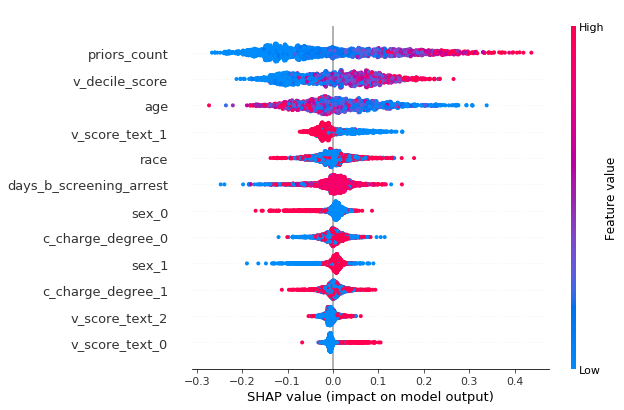

In [27]:
exp_transf = shap.TreeExplainer(model=model_transf_rf, data=X_train_transf)
shap_values_transf = exp_transf.shap_values(X_test_transf)
shap.summary_plot(shap_values_transf[0], X_test_transf, feature_names=dataset.feature_names)

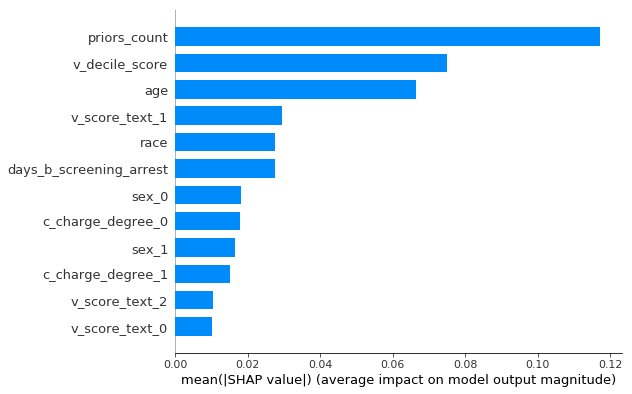

In [28]:
shap.summary_plot(shap_values_transf[0], X_test_transf, feature_names=dataset.feature_names, 
                  plot_type="bar")

In [29]:
df_feat = pd.DataFrame({'feature_names': dataset.feature_names, 
                        'value': np.abs(shap_values_transf[0]).mean(axis=0)})
df_feat = df_feat.sort_values(by='value', ascending=False).reset_index(drop=True)
feat_import_transf_rf = df_feat.loc[df_feat['feature_names'] == name_protect, 'value'].iloc[0]
pos_transf_rf = df_feat[df_feat['feature_names'] == name_protect].index[0]
df_feat

,feature_names,value
0,priors_count,0.117359
1,v_decile_score,0.075061
2,age,0.066351
3,v_score_text_1,0.029525
4,race,0.027644
5,days_b_screening_arrest,0.027614
6,sex_0,0.018086
7,c_charge_degree_0,0.017829
8,sex_1,0.016570
9,c_charge_degree_1,0.015090


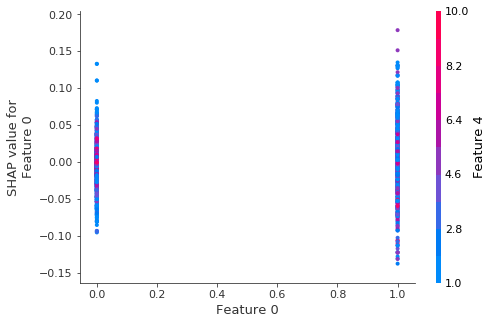

In [30]:
shap.dependence_plot(position, shap_values_transf[0], dataset_test.features)

In [31]:
df = pd.DataFrame({'shap': shap_values_transf[0][:, position], 
                   'feat_value': dataset_test.features[:, position]})
unp_value_transf_rf = df.loc[df['feat_value'] == 0, 'shap'].mean()
priv_value_transf_rf = df.loc[df['feat_value'] == 1, 'shap'].mean()
print('Media valores SHAP classe não priveligiada: ', unp_value_transf_rf)
print('Media valores SHAP classe priveligiada: ', priv_value_transf_rf)

Media valores SHAP classe não priveligiada:  -0.003538797488052662
Media valores SHAP classe priveligiada:  0.007485346317707327


In [32]:
results = stats.ttest_ind(df.loc[df['feat_value'] == 1, 'shap'], 
                          df.loc[df['feat_value'] == 0, 'shap'], equal_var=False)

alpha = 0.05
if (results[0] > 0) & (results[1]/2 < alpha):
    print("reject null hypothesis, mean of group privilegiad is greater than mean of unprivilegiad")
    priv_greater_unpriv = 1
else:
    print("accept null hypothesis")
    priv_greater_unpriv = 0    

reject null hypothesis, mean of group privilegiad is greater than mean of unprivilegiad


In [0]:
lst_shape.append(('rf_transf', feat_import_transf_rf, pos_transf_rf,
                  unp_value_transf_rf, priv_value_transf_rf, priv_greater_unpriv))

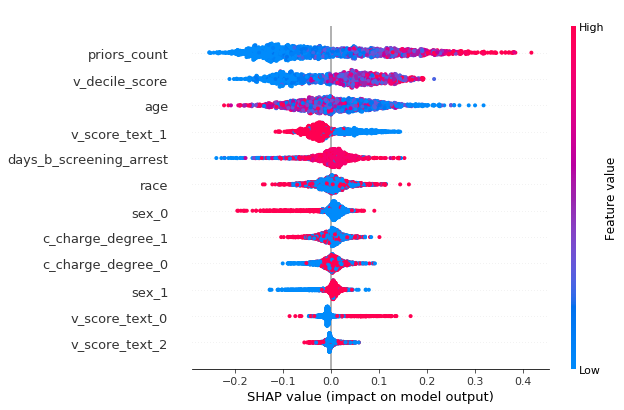

In [34]:
exp_orig = shap.TreeExplainer(model=model_orig_rf, data=X_train_orig)
shap_values_orig = exp_orig.shap_values(X_test_orig)
shap.summary_plot(shap_values_orig[0], X_test_orig, feature_names=dataset.feature_names)

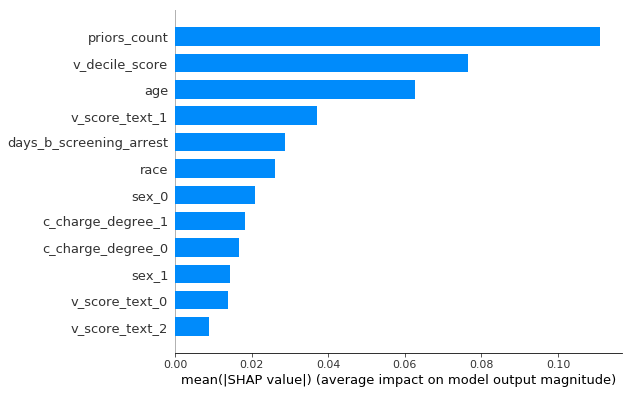

In [35]:
shap.summary_plot(shap_values_orig[0], X_test_orig, feature_names=dataset.feature_names, 
                  plot_type="bar")

In [36]:
df_feat = pd.DataFrame({'feature_names': dataset.feature_names, 
                        'value': np.abs(shap_values_orig[0]).mean(axis=0)})
df_feat = df_feat.sort_values(by='value', ascending=False).reset_index(drop=True)
feat_import_orig_rf = df_feat.loc[df_feat['feature_names'] == name_protect, 'value'].iloc[0]
pos_orig_rf = df_feat[df_feat['feature_names'] == name_protect].index[0]
df_feat

,feature_names,value
0,priors_count,0.111115
1,v_decile_score,0.076428
2,age,0.062560
3,v_score_text_1,0.037066
4,days_b_screening_arrest,0.028782
5,race,0.026029
6,sex_0,0.020948
7,c_charge_degree_1,0.018166
8,c_charge_degree_0,0.016701
9,sex_1,0.014271


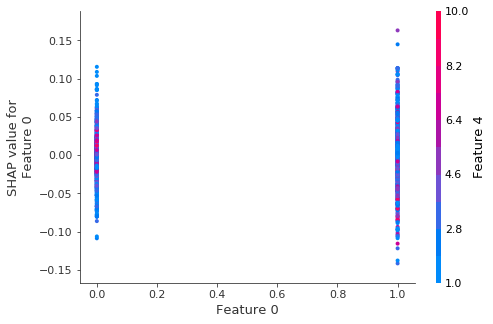

In [37]:
shap.dependence_plot(position, shap_values_orig[0], dataset_test.features)

In [38]:
df = pd.DataFrame({'shap': shap_values_orig[0][:, position], 
                   'feat_value': dataset_test.features[:, position]})
unp_value_orig_rf = df.loc[df['feat_value'] == 0, 'shap'].mean()
priv_value_orig_rf = df.loc[df['feat_value'] == 1, 'shap'].mean()
print('Media valores SHAP classe não priveligiada: ', unp_value_orig_rf)
print('Media valores SHAP classe priveligiada: ', priv_value_orig_rf)

Media valores SHAP classe não priveligiada:  0.00038264468135347935
Media valores SHAP classe priveligiada:  0.003755384494271106


In [39]:
results = stats.ttest_ind(df.loc[df['feat_value'] == 1, 'shap'], 
                          df.loc[df['feat_value'] == 0, 'shap'], equal_var=False)

alpha = 0.05
if (results[0] > 0) & (results[1]/2 < alpha):
    print("reject null hypothesis, mean of group privilegiad is greater than mean of unprivilegiad")
    priv_greater_unpriv = 1
else:
    print("accept null hypothesis")
    priv_greater_unpriv = 0    

reject null hypothesis, mean of group privilegiad is greater than mean of unprivilegiad


In [0]:
lst_shape.append(('rf_orig', feat_import_orig_rf, pos_orig_rf,
                  unp_value_orig_rf, priv_value_orig_rf, priv_greater_unpriv))

In [41]:
prop_feat_import_rf = (feat_import_orig_rf - feat_import_transf_rf) / feat_import_orig_rf
print('Proporção diminuição da importancia: ', prop_feat_import_rf)

Proporção diminuição da importancia:  -0.06205478744837198


### Logistic Regression

Estimating transforms: 100%|██████████| 1000/1000 [00:01<00:00, 907.59it/s]


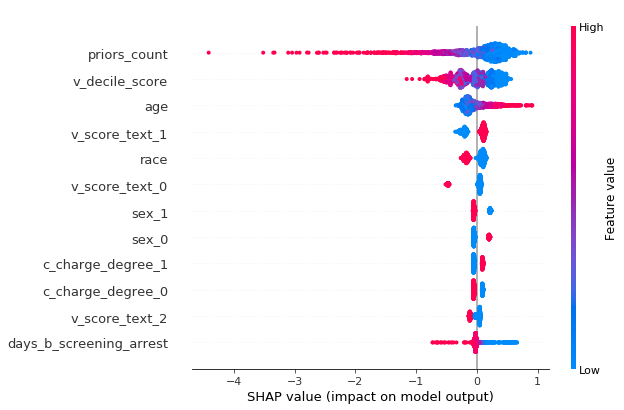

In [42]:
exp_transf_lr = shap.LinearExplainer(model_transf_lr, X_train_transf, feature_dependence="correlation")
shap_values_transf_lr = exp_transf_lr.shap_values(X_test_transf)
shap.summary_plot(shap_values_transf_lr, X_test_transf, feature_names=dataset.feature_names)

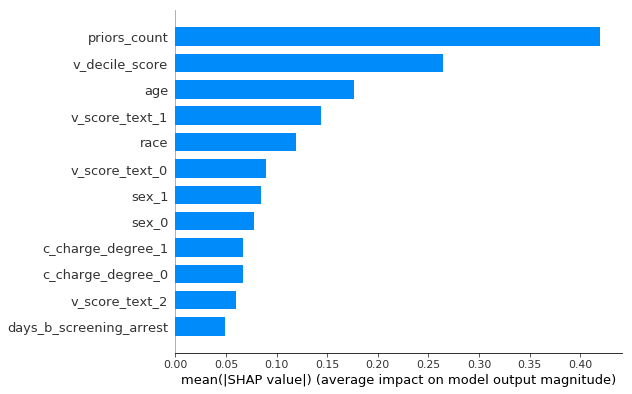

In [43]:
shap.summary_plot(shap_values_transf_lr, X_test_transf, feature_names=dataset.feature_names, plot_type="bar")

In [44]:
df_feat = pd.DataFrame({'feature_names': dataset.feature_names, 
                        'value': np.abs(shap_values_transf_lr).mean(axis=0)})
df_feat = df_feat.sort_values(by='value', ascending=False).reset_index(drop=True)
feat_import_transf_lr = df_feat.loc[df_feat['feature_names'] == name_protect, 'value'].iloc[0]
pos_transf_lr = df_feat[df_feat['feature_names'] == name_protect].index[0]
df_feat

,feature_names,value
0,priors_count,0.419939
1,v_decile_score,0.264434
2,age,0.176174
3,v_score_text_1,0.143436
4,race,0.119486
5,v_score_text_0,0.089825
6,sex_1,0.084348
7,sex_0,0.077446
8,c_charge_degree_1,0.067152
9,c_charge_degree_0,0.066711


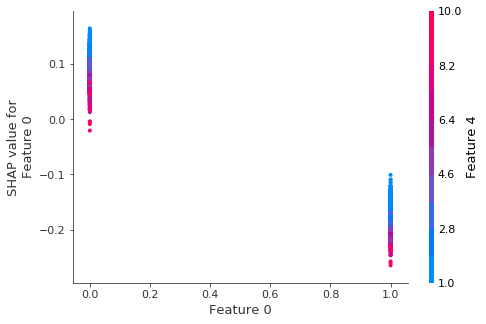

In [45]:
shap.dependence_plot(position, shap_values_transf_lr, dataset_test.features)

In [46]:
df = pd.DataFrame({'shap': shap_values_transf_lr[:, position], 
                   'feat_value': dataset_test.features[:, position]})
unp_value_transf_lr = df.loc[df['feat_value'] == 0, 'shap'].mean()
priv_value_transf_lr = df.loc[df['feat_value'] == 1, 'shap'].mean()
print('Media valores SHAP classe não priveligiada: ', unp_value_transf_lr)
print('Media valores SHAP classe priveligiada: ', priv_value_transf_lr)

Media valores SHAP classe não priveligiada:  0.09110642459713614
Media valores SHAP classe priveligiada:  -0.17603202252593017


In [47]:
results = stats.ttest_ind(df.loc[df['feat_value'] == 1, 'shap'], 
                          df.loc[df['feat_value'] == 0, 'shap'], equal_var=False)

alpha = 0.05
if (results[0] > 0) & (results[1]/2 < alpha):
    print("reject null hypothesis, mean of group privilegiad is greater than mean of unprivilegiad")
    priv_greater_unpriv = 1
else:
    print("accept null hypothesis")
    priv_greater_unpriv = 0    

accept null hypothesis


In [0]:
lst_shape.append(('lr_transf', feat_import_transf_lr, pos_transf_lr, 
                  unp_value_transf_lr, priv_value_transf_lr, priv_greater_unpriv))

Estimating transforms: 100%|██████████| 1000/1000 [00:01<00:00, 940.49it/s]


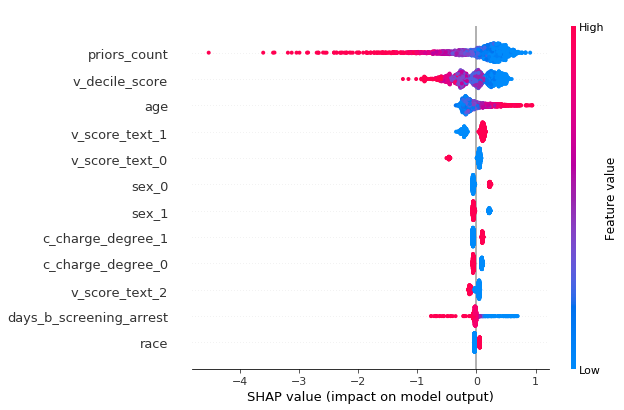

In [49]:
# exp_orig = shap.TreeExplainer(model, X_train_orig)
exp_orig_lr = shap.LinearExplainer(model_orig_lr, X_train_orig, feature_dependence="correlation")
shap_values_orig_lr = exp_orig_lr.shap_values(X_test_orig)
shap.summary_plot(shap_values_orig_lr, X_test_orig, feature_names=dataset.feature_names)

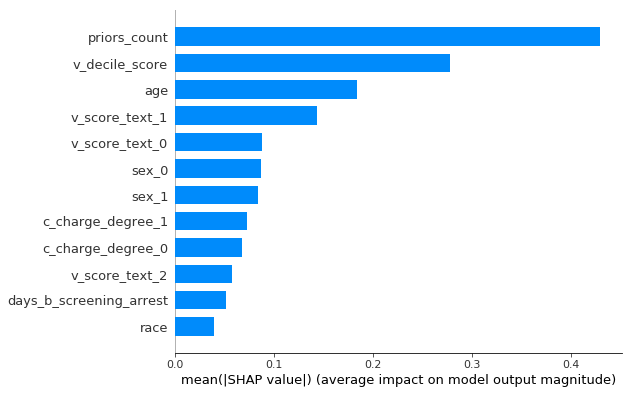

In [50]:
shap.summary_plot(shap_values_orig_lr, X_test_orig, feature_names=dataset.feature_names, 
                  plot_type="bar")

In [51]:
df_feat = pd.DataFrame({'feature_names': dataset.feature_names, 
                        'value': np.abs(shap_values_orig_lr).mean(axis=0)})
df_feat = df_feat.sort_values(by='value', ascending=False).reset_index(drop=True)
feat_import_orig_lr = df_feat.loc[df_feat['feature_names'] == name_protect, 'value'].iloc[0]
pos_orig_lr = df_feat[df_feat['feature_names'] == name_protect].index[0]
df_feat

,feature_names,value
0,priors_count,0.430296
1,v_decile_score,0.277908
2,age,0.183703
3,v_score_text_1,0.143860
4,v_score_text_0,0.087924
5,sex_0,0.087067
6,sex_1,0.083421
7,c_charge_degree_1,0.072545
8,c_charge_degree_0,0.067904
9,v_score_text_2,0.057229


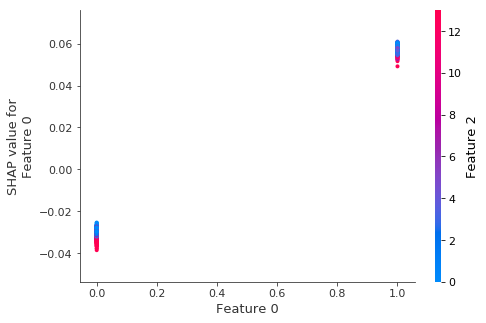

In [52]:
shap.dependence_plot(position, shap_values_orig_lr, dataset_test.features)

In [53]:
df = pd.DataFrame({'shap': shap_values_orig_lr[:, position], 
                   'feat_value': dataset_test.features[:, position]})
unp_value_orig_lr = df.loc[df['feat_value'] == 0, 'shap'].mean()
priv_value_orig_lr = df.loc[df['feat_value'] == 1, 'shap'].mean()
print('Media valores SHAP classe não priveligiada: ', unp_value_orig_lr)
print('Media valores SHAP classe priveligiada: ', priv_value_orig_lr)

Media valores SHAP classe não priveligiada:  -0.030004489155911165
Media valores SHAP classe priveligiada:  0.057159283620048955


In [54]:
results = stats.ttest_ind(df.loc[df['feat_value'] == 1, 'shap'], 
                          df.loc[df['feat_value'] == 0, 'shap'], equal_var=False)

alpha = 0.05
if (results[0] > 0) & (results[1]/2 < alpha):
    print("reject null hypothesis, mean of group privilegiad is greater than mean of unprivilegiad")
    priv_greater_unpriv = 1
else:
    print("accept null hypothesis")
    priv_greater_unpriv = 0    

reject null hypothesis, mean of group privilegiad is greater than mean of unprivilegiad


In [0]:
lst_shape.append(('lr_orig', feat_import_orig_lr, pos_orig_lr, unp_value_orig_lr, priv_value_orig_lr,
                 priv_greater_unpriv))

In [56]:
prop_feat_import_lr = (feat_import_orig_lr - feat_import_transf_lr) / feat_import_orig_lr
print('Proporção diminuição da importancia: ', prop_feat_import_lr)

Proporção diminuição da importancia:  -2.0585668998422073


In [57]:
df_shap = pd.DataFrame(lst_shape, columns=['name_exp', 'feat_imp', 'shap_rank', 'mean_unpriv', 'mean_priv', 
                                           'priv_greater_unpriv'])
df_final = pd.merge(df_shap, df_final, on='name_exp')
df_final

,name_exp,feat_imp,shap_rank,mean_unpriv,mean_priv,priv_greater_unpriv,dataset,acc_test,1_disp_impact_bin,mean_difference,1_disp_impact_clf,avg_odds,equal_opport,false_discovery_rate,entropy_index,consistency
0,rf_transf,0.027644,4,-0.003539,0.007485,1,adult,0.621490,0.184631,-0.108448,0.184631,-0.080918,-0.086583,0.091454,0.197665,0.765767
1,rf_orig,0.026029,5,0.000383,0.003755,1,adult,0.617711,0.222003,-0.134351,0.222003,-0.115880,-0.070144,0.043080,0.199433,0.770410
2,lr_transf,0.119486,4,0.091106,-0.176032,0,adult,0.656587,-0.000330,0.000207,-0.000330,0.032952,0.042058,0.101004,0.140874,0.905616
3,lr_orig,0.039066,11,-0.030004,0.057159,1,adult,0.665767,0.218033,-0.160879,0.218033,-0.131754,-0.097775,0.056130,0.136133,0.955832


In [0]:
df_final.to_csv(path + 'result/resultado_compas.csv')